# Benchmark M3.1: Water flow in roots - Single root

by Daniel Leitner, Andrea Schnepf, Felicien Meunier

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
from van_genuchten import * 

## Comparison of numerical solutions to reference solution

We compare different numerical codes by solving the benchmarking problems. 

In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code should they be available in the subfolder 'M3.1 Model descriptions'.

### Result data format of M3.1

For an automatic comparison of the numerical results, results are stored in a text file consisting of two rows, containing comma separated depth values [cm] in the first, and pressure head [cm] in the second row, located in the folder `M3.1 Numerical results`.

### Comparison to the analytical solution

We set up the  parameters of the single root

In [2]:
L = 50            # length of single straight root [cm]
a = 0.2           # root radius  [cm]
kx = 0.0432       # root axial conductivity [cm^3 / day] 
kr = 1.73e-4      # root radial conductivity [1 / day]
p_s = -200        # soil matric potiential [cm]
p0 = -1000        # dirichlet bc at root collar [cm]

and solve the problem analytically

In [3]:
c = 2*a*np.pi*kr/kx
p_r = lambda z: p_s + d[0]*np.exp(np.sqrt(c)*z) + d[1]*np.exp(-np.sqrt(c)*z) # Eqn 6

AA = np.array([[1,1], [np.sqrt(c)*np.exp(np.sqrt(c)*(-L)), -np.sqrt(c)*np.exp(-np.sqrt(c)*(-L))] ]) 
bb = np.array([p0-p_s, -1]) 
d = np.linalg.solve(AA, bb) # Eqn 10

In the following we compare this analytical solution to the numerical results

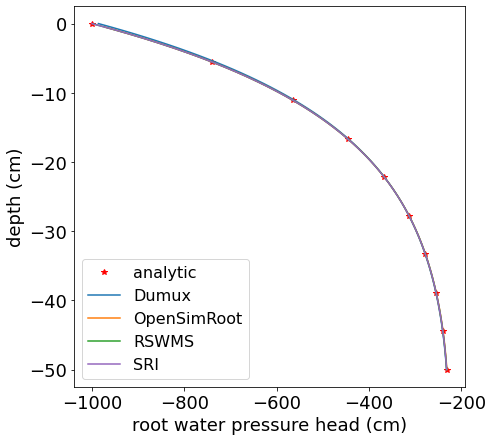

In [4]:
fig=plt.figure(figsize=(7,7))   # analytical solution
y = np.linspace(0,-50,10)
plt.plot(list(map(p_r, y)),y,"r*")

j = 0 # number of files
name, nrsme, nn = [], [], []
l = ["analytic"]
for dirname, dirnames, filenames in os.walk('M3.1 Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(f) 
            data = np.loadtxt("M3.1 Numerical results/"+f, delimiter = ',')
            if f == 'RSWMS': # hack to remvoe nan values
                data = np.array([data[0, ~np.isnan(data[0,:])], data[1, ~np.isnan(data[1,:])]])                
            plt.plot(data[1,:], -np.abs(data[0,:]), color = col[i], linewidth = 1.5, alpha = 1)              
            j += 1     
            # Evaluate
            n = len(data[1,:])
            nn.append(n)
            t_a = np.linspace(-45,-5,100)
            pr_a = list(map(p_r, t_a))          
            interp = interp1d(-np.abs(data[0,:]), data[1,:],  kind = 'linear', fill_value = 'extrapolate' ) 
            pr_n = interp(t_a)            
            # calculate measures
            nrsme.append(nRMSE(pr_a,pr_n))   
        except Exception as ex:
            print("Something went wrong with file "+f)    
            raise
            
plt.xlabel("root water pressure head (cm)")
plt.ylabel("depth (cm)")
plt.legend(l, loc = 3)
plt.savefig('m31_results.png', dpi=300, bbox_inches = "tight")
plt.show()

Additionally, we create a table using normalised RSME as an error measure (which were calculated in the cell above)

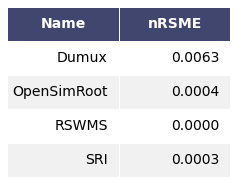

In [5]:
import pandas as pd 

data_ = np.array([l[1:], nrsme])
data_ = np.array(data_.transpose())
df = pd.DataFrame(data_, columns = ['Name','nRSME'] ) # Create the pandas DataFrame 
df['nRSME'] = df['nRSME'].astype(float)
df['nRSME'] = df['nRSME'].map('{:,.4f}'.format)
#df['nNSE'] = df['nNSE'].astype(float)
#df['nNSE'] = df['nNSE'].map('{:,.4f}'.format)

df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_m3l.png")

## References

Doussan, C., Pierret, A., Garrigues, E., and Pages, L. (2006). Water uptake by plant roots: II - Modelling of water transfer in the soil root-system with explicit account of flow within the root system - comparison with experiments. *Plant and Soil*, 283(1-2):99–117.

Roose, T., and Fowler, A. C. (2004). A model for water uptake by plant roots. *Journal of Theoretical Biology*, 228(2):155–171.

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., and Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053.
